In [1896]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr

from sklearn.metrics import accuracy_score

import logging

import sys
import os

from scipy.stats import binom_test
from mpl_toolkits.mplot3d import Axes3D


In [1199]:
class SuppressOutput:
    def __enter__(self):
        self.stdout = sys.stdout
        self.stderr = sys.stderr
        self.devnull = open(os.devnull, 'w')
        sys.stdout = self.devnull
        sys.stderr = self.devnull

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self.stdout
        sys.stderr = self.stderr


In [1200]:
def filter_data(ticker_list, start, end):

    data_list = []

    for ticker in ticker_list:
        with SuppressOutput():
            data = yf.download(ticker, start=start, end=end)
        data_list.append(data)

    return dict(zip(ticker_list, data_list))
        

    

In [2143]:
def create_data(ticker, ticker_name, l_wind, s_wind, wind):

    df = pd.DataFrame(ticker)
    date = df.index.tolist()
    df['Date'] = pd.to_datetime(date)

    df['Index'] = list(range(0, len(df['Date'])))

    large_window = l_wind  # Moving average window size
    small_window = s_wind
    window = wind

    # Calculate the moving average
    df['LMA'] = df['Open'].ewm(span=large_window, adjust=False).mean()
    df['SMA'] = df['Open'].ewm(span=small_window, adjust=False).mean()
    df['MA'] = df['Open'].ewm(span=window, adjust=False).mean()

    # df['LMA'] = df['Open'].rolling(window=large_window).mean()
    # df['SMA'] = df['Open'].rolling(window=small_window).mean()
    # df['MA'] = df['Open'].rolling(window=window).mean()

    # print(df)


    # Create a plot
    # plt.figure(figsize=(20, 8))
    # plt.plot(df['Date'], df['Open'], label='Original Data')
    # plt.plot(df['Date'], df['LMA'], label=f'Long Moving Average ({large_window} days)')
    # plt.plot(df['Date'], df['SMA'], label=f'Short Moving Average ({small_window} days)')
    # plt.plot(df['Date'], df['MA'], label = f'Moving Average ({window} days)')
    # plt.xlabel('Date')
    # plt.ylabel('Value')
    # plt.title('Moving Average Plot')
    # plt.legend()
    # plt.grid(True)
    # path = "Experimental_Figures/" + ticker_name + ".png"
    # plt.savefig(path)
    # plt.close()

    return df








In [2443]:
def create_train_set(ticker_list, start_date, end_date, large_window, short_window, window):
    ticker_dict = filter_data(ticker_list, start_date, end_date)

    for ticker in ticker_dict.keys():
        data = ticker_dict.get(ticker)
        ticker_dict[ticker] = create_data(data, ticker, large_window, short_window, window)

    return ticker_dict


def train_model(ticker_dict, large_window, short_window, window):

    train_set = []

    for ticker in ticker_dict.keys():
        train_set = train_set + get_crossover_data(ticker_dict[ticker], window)

    lma = [lma for _, lma, _ in train_set]
    sma = [sma for _, _, sma in train_set]
    gain = [gain for gain, _, _ in train_set]
    # ma = [ma for _,_,_ in train_set]

    print(gain.count(1) / len(gain))
    print(len(gain))


    # Create a 3D scatter plot
    fig = plt.figure(figsize = (20, 8))
    # ax = fig.add_subplot(111, projection='3d')
    plt.scatter(lma, sma, c=gain, cmap='bwr', marker='o')

    # Add color bar
    cbar = plt.colorbar()
    cbar.set_label('Binary Value')

    # Set labels and title
    # ax.set_xlabel('X-axis')
    # ax.set_ylabel('Y-axis')
    # ax.set_zlabel('Z-axis')
    # ax.set_title('Scatter Plot with Binary Color')

    # Show the plot
    plt.show()

    target = [target for target, _, _ in train_set]
    features = [(x,y) for _,x,y in train_set]

    print("Valid crossovers:", len(target))
    print("Successful crossovers:", target.count(1))

    model = RandomForestClassifier(n_estimators = 30, max_depth = 4)
    # model = LogisticRegression()
    model.fit(features, target)

    # Make predictions on the test set
    y_pred = model.predict(features)

    preds = list(y_pred)

    print(preds.count(1))

    correct_signals = 0

    trades = 0

    for i in range(0, len(preds)):
        confidence = model.predict_proba(np.array(features[i]).reshape(1, -1))[0, 1]
        if preds[i] == 1 and confidence > .85:
            trades += 1
            if preds[i] == target[i]:
                correct_signals += 1

    print("Amount of trades", trades)
    print("Amount of successful trades", correct_signals)
    # Calculate accuracy
    accuracy = accuracy_score(target, y_pred)
    print("Accuracy:", accuracy)

    return model



In [2474]:
def create_test_set(ticker_list, start_date, end_date, large_window, short_window, window):
    ticker_dict = filter_data(ticker_list, start_date, end_date)

    for ticker in ticker_dict.keys():
        data = ticker_dict.get(ticker)
        ticker_dict[ticker] = create_data(data, ticker, large_window, short_window, window)

    return ticker_dict

def test_model(ticker_dict, large_window, short_window, window, model):

    train_set = []

    for ticker in ticker_dict.keys():
        train_set = train_set + get_crossover_data(ticker_dict[ticker], window)

    target = [target for target, _, _ in train_set]
    features = [(x,y) for _,x,y in train_set]

    print("Valid crossovers:", len(target))
    print("Successful crossovers:", target.count(1))

    # Make predictions on the test set
    y_pred = model.predict(features)

    preds = list(y_pred)

    print("Predicted successful crossovers:", preds.count(1))

    correct_signals = 0

    trades = 0

    for i in range(0, len(preds)):
        confidence = model.predict_proba(np.array(features[i]).reshape(1, -1))[0, 1]
        if preds[i] == 1 and confidence > .9:
            trades += 1
            if preds[i] == target[i]:
                correct_signals += 1

    print("Amount of trades", trades)
    print("Amount of successful trades", correct_signals)
    # Calculate accuracy
    accuracy = accuracy_score(target, y_pred)
    print("Accuracy:", accuracy)

    return (trades / correct_signals, binom_test(correct_signals, trades, .5))



In [2046]:
window = 200
large_window = 120
small_window = 30


In [1]:
start_date = '2020-09-01'
end_date = '2023-08-31'

recent_start = '2022-08-31'
recent_end = '2023-08-31'

long_start = '2013-08-31'
long_end = '2023-08-31'

train_start = '2010-08-31'
train_end = '2018-08-31'

sp_df = pd.read_csv('symbols.csv')

sp_list = list(sp_df['Symbol'])

common_list = commonly_traded_stocks = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "NFLX", "JPM", "V",
    "JNJ", "PG", "WMT", "KO", "MCD", "HD", "BA", "INTC", "CRM", "ADBE",
    "PFE", "T", "XOM", "CVX", "IBM", "GE", "VZ", "DIS", "MA", "BAC",
    "CMCSA", "TMO", "MRK", "UNH", "NKE", "WFC", "PYPL", "CSCO", "PEP",
    "PM", "BMY", "ABBV", "LLY", "CVS", "GILD", "QCOM", "DHR", "AMGN",
    "COST", "MCD", "TXN", "LIN", "NOW", "PFE", "LMT", "NEE", "TGT",
    "FDX", "HON", "ACN", "UNH", "LOW", "KHC", "DUK", "AAL", "NOC",
    "MET", "INTU", "UPS", "C", "SBUX", "ORCL", "NEE", "AMD", "DE",
    "ISRG", "CAT", "AMAT", "MO", "WBA", "MDT", "VRTX", "MS", "SYK",
    "MMM", "TMO", "PLD", "INTC", "ADI", "GS", "GM", "BDX", "VLO",
    "CL", "CI", "MDLZ", "SPGI", "CCI", "SO", "ANTM", "FISV", "AXP",
    "GILD", "SYF", "BDX", "SPG", "TROW", "CNC", "DELL", "ZTS", "SNPS"
]


sp_mid = create_train_set(sp_list, start_date, end_date, large_window, small_window, window)
sp_short = create_train_set(sp_list, recent_start, recent_end, large_window, small_window, window)
sp_long = create_train_set(sp_list, train_start, train_end, large_window, small_window, window)

common_mid = create_train_set(common_list, start_date, end_date, large_window, small_window, window)
common_short = create_train_set(common_list, recent_start, recent_end, large_window, small_window, window)
common_long = create_train_set(common_list, train_start, train_end, large_window, small_window, window)

NameError: name 'pd' is not defined

In [2461]:
def get_crossover_data(dataset, window):
    train_data = []
    for i in range(window + 50, len(dataset) - 80):
        if dataset['SMA'][i - 31] > dataset['LMA'][i - 31] and dataset['SMA'][i - 30] <= dataset['LMA'][i - 30]:
            lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 60]) / dataset['LMA'][i - 60] / 60
            sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 60]) / dataset['SMA'][i - 60] / 60
            ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]
            angle_rad = math.atan(abs(sma_change - ma_change) / (1 + sma_change * ma_change))
            predictor = dataset['LMA'][i - 30] / dataset['SMA'][i - 30]
            if(lma_change < -.00075):
                future = list(dataset['High'][i+2:i+80])
                gain = 1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else 0
                train_data.append((gain, lma_change, sma_change))
    return train_data

0.7204968944099379
322


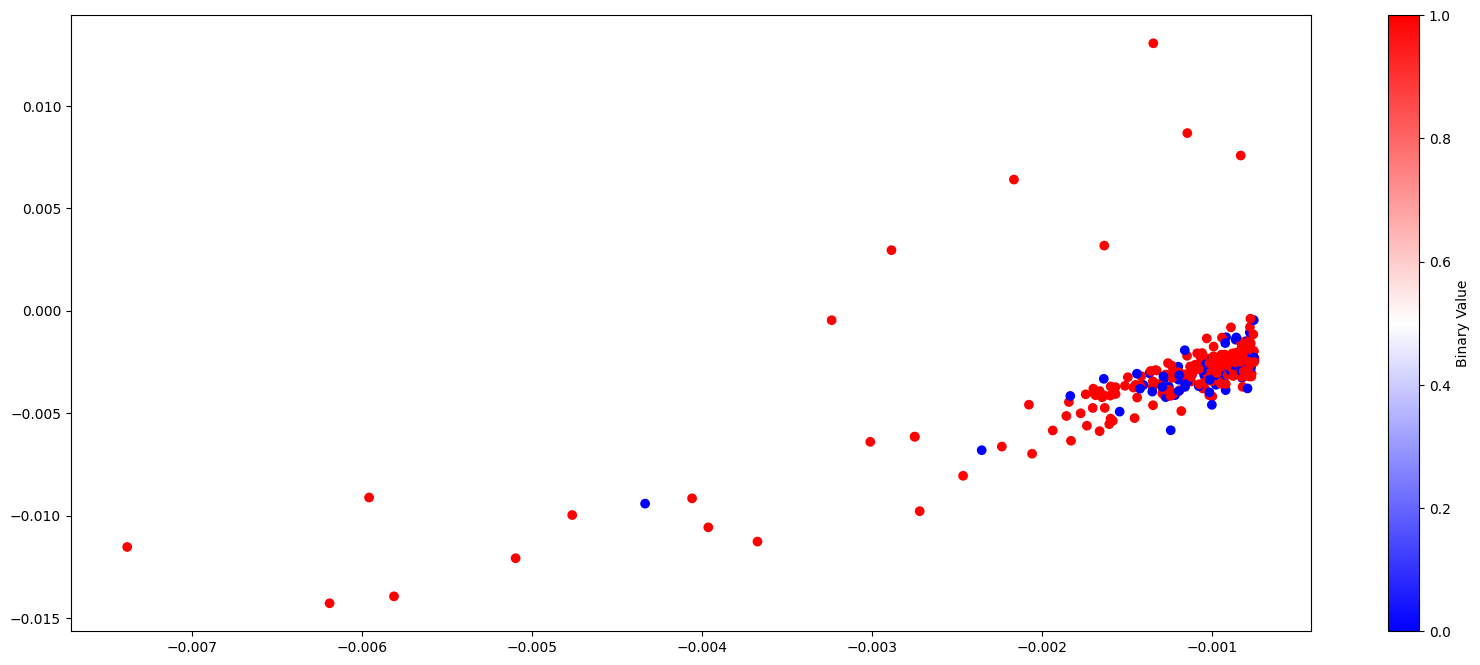

Valid crossovers: 322
Successful crossovers: 232
322
Amount of trades 40
Amount of successful trades 40
Accuracy: 0.7204968944099379


In [2463]:
import math
model = train_model(sp_mid, large_window, small_window, window)

In [2475]:
test_model(sp_long, large_window, small_window, window, model)

Valid crossovers: 151
Successful crossovers: 99
Predicted successful crossovers: 151
Amount of trades 12
Amount of successful trades 7
Accuracy: 0.6556291390728477


C:\Users\sayuj\AppData\Local\Temp\ipykernel_15212\1832918762.py:47: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  return (trades / correct_signals, binom_test(correct_signals, trades, .5))


(1.7142857142857142, 0.7744140625)

AES
Date: 2020-04-23 00:00:00, Buy: 12.740, Sell Date: 2020-08-17 00:00:00, Sell: 17.600, Move: 0.381, Held for 78
AFL
Date: 2020-04-01 00:00:00, Buy: 31.630, Sell Date: 2020-07-27 00:00:00, Sell: 36.580, Move: 0.156, Held for 78
AXP
Date: 2020-04-20 00:00:00, Buy: 80.730, Sell Date: 2020-08-12 00:00:00, Sell: 104.760, Move: 0.298, Held for 78
AMP
Date: 2020-04-21 00:00:00, Buy: 106.560, Sell Date: 2020-08-13 00:00:00, Sell: 159.670, Move: 0.498, Held for 78
APA
Date: 2020-04-21 00:00:00, Buy: 9.000, Sell Date: 2020-08-13 00:00:00, Sell: 15.520, Move: 0.724, Held for 78
AIV
Date: 2020-04-20 00:00:00, Buy: 4.711, Sell Date: 2020-08-03 00:00:00, Sell: 5.146, Move: 0.092, Held for 71
AVB
Date: 2020-04-24 00:00:00, Buy: 160.590, Sell Date: 2020-06-09 00:00:00, Sell: 175.000, Move: 0.090, Held for 29
BAC
Date: 2020-04-17 00:00:00, Buy: 22.570, Sell Date: 2020-08-11 00:00:00, Sell: 27.280, Move: 0.209, Held for 78
BIG
Date: 2020-04-13 00:00:00, Buy: 19.390, Sell Date: 2020-08-05 00:00:00, Se

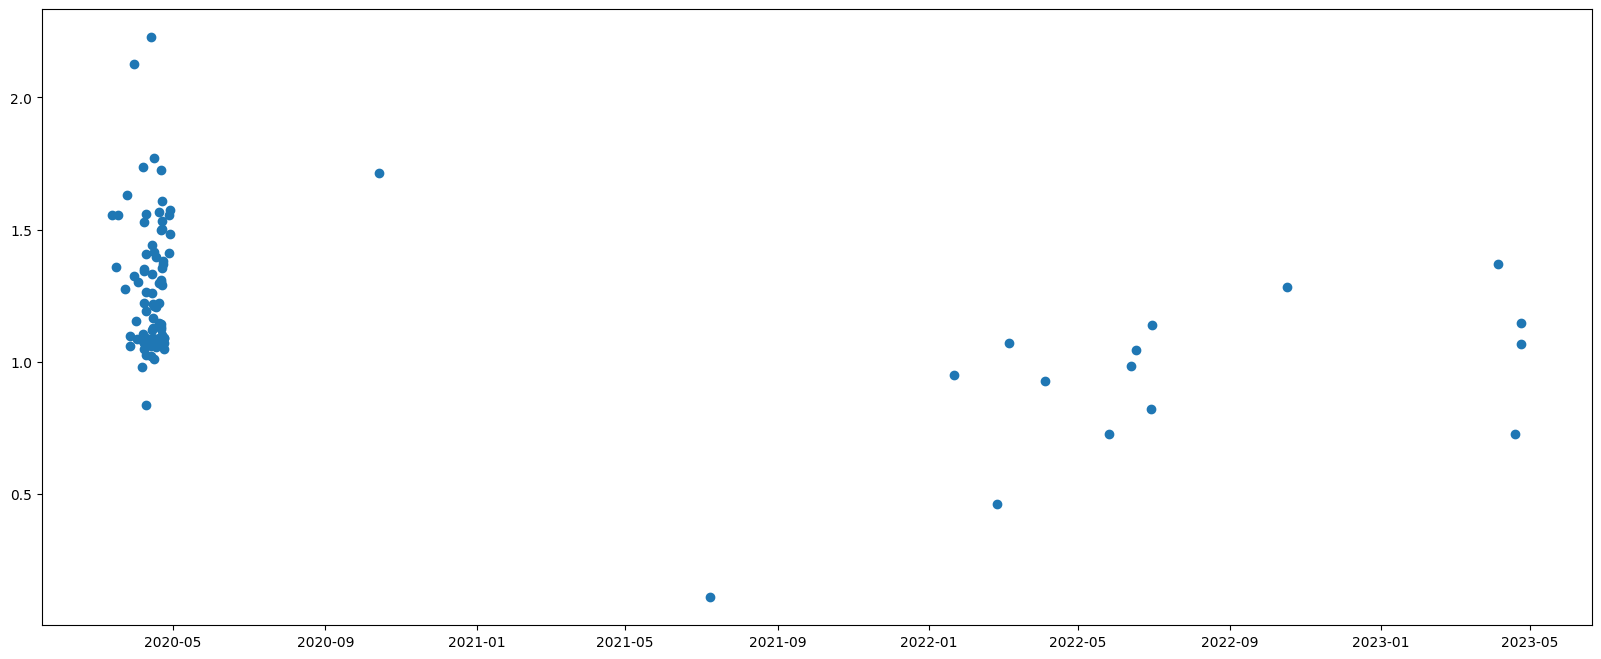

In [2468]:


def get_simulation_data(ticker_dict, window, model):
    trade_data = []
    for ticker in ticker_dict.keys():
        dataset = ticker_dict[ticker]
        for i in range(window + 30, len(dataset) - 80):
            if dataset['SMA'][i - 31] > dataset['LMA'][i - 31] and dataset['SMA'][i - 30] <= dataset['LMA'][i - 30]:
                lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 60]) / dataset['LMA'][i - 60] / 60
                sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 60]) / dataset['SMA'][i - 60] / 60
                ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]
                angle_rad = math.atan(abs(sma_change - ma_change) / (1 + sma_change * ma_change))
                predictor = dataset['LMA'][i - 30] / dataset['SMA'][i - 30]
                if(model.predict_proba(np.array([lma_change, sma_change]).reshape(1, -1))[0, 1] > .85):
                    date = dataset['Date'][i]
                    buy = dataset['Open'][i + 1]
                    future = list(dataset['High'][i+2:i+80])
                    sell = 0
                    # sell = dataset['Open'][i + 1] * 1.1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else dataset['Close'][i + 80]
                    for n in range(i+2, i + 80):
                        if dataset['High'][n] > dataset['Open'][i + 1] * 1.1:
                            sell = dataset['Open'][n + 1]
                            sell_date = dataset['Date'][n + 1]
                            hold_period = n - (i + 1)
                        #     break
                        # if dataset['Low'][n] < dataset['Open'][i+1] * .8:
                        #     sell = dataset['Open'][i+1] * .8
                        #     sell_date = dataset['Date'][n + 1]
                        #     hold_period = n - (i + 1)
                        #     break
                    if sell == 0:
                        sell = dataset['Close'][i + 80]
                        sell_date = dataset['Date'][i + 80]
                        hold_period = i + 80 - (i + 1)
                    trade_data.append((date, buy, sell, sell_date, hold_period, ticker))
    return trade_data

def get_upward_data(ticker_dict, window):
    trade_data = []
    for ticker in ticker_dict.keys():
        dataset = ticker_dict[ticker]
        for i in range(window + 30, len(dataset) - 80):
            if dataset['SMA'][i - 31] <= dataset['LMA'][i - 31] and dataset['SMA'][i - 30] > dataset['LMA'][i - 30]:
                lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 60]) / dataset['LMA'][i - 60] / 60
                sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 60]) / dataset['SMA'][i - 60] / 60
                ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]
                angle_rad = math.atan(abs(sma_change - ma_change) / (1 + sma_change * ma_change))
                predictor = dataset['LMA'][i - 30] / dataset['SMA'][i - 30]
                if(lma_change > .0015):
                    date = dataset['Date'][i]
                    buy = dataset['Open'][i + 1]
                    future = list(dataset['High'][i+2:i+40])
                    sell = 0
                    # sell = dataset['Open'][i + 1] * 1.1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else dataset['Close'][i + 80]
                    for n in range(i+2, i + 40):
                        if dataset['High'][n] > dataset['Open'][i + 1] * 1.05:
                            sell = dataset['Open'][n + 1]
                            sell_date = dataset['Date'][n + 1]
                            hold_period = n - (i + 1)
                            break
                        if dataset['Low'][n] < dataset['Open'][i+1] * .9:
                            sell = dataset['Open'][i+1] * .9
                            sell_date = dataset['Date'][n + 1]
                            hold_period = n - (i + 1)
                            break
                    if sell == 0:
                        sell = dataset['Close'][i + 40]
                        sell_date = dataset['Date'][i + 40]
                        hold_period = i + 40 - (i + 1)
                    trade_data.append((date, buy, sell, sell_date, hold_period, ticker))
    return trade_data

def get_downward_data(ticker_dict, window):
    trade_data = []
    for ticker in ticker_dict.keys():
        dataset = ticker_dict[ticker]
        for i in range(window + 30, len(dataset) - 80):
            if dataset['SMA'][i - 31] <= dataset['LMA'][i - 31] and dataset['SMA'][i - 30] > dataset['LMA'][i - 30]:
                lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 60]) / dataset['LMA'][i - 60] / 60
                sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 60]) / dataset['SMA'][i - 60] / 60
                ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]
                angle_rad = math.atan(abs(sma_change - ma_change) / (1 + sma_change * ma_change))
                predictor = dataset['LMA'][i - 30] / dataset['SMA'][i - 30]
                if(lma_change < -.001):
                    date = dataset['Date'][i]
                    buy = dataset['Open'][i + 1]
                    future = list(dataset['High'][i+2:i+40])
                    sell = 0
                    # sell = dataset['Open'][i + 1] * 1.1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else dataset['Close'][i + 80]
                    for n in range(i+2, i + 40):
                        if dataset['High'][n] > dataset['Open'][i + 1] * 1.05:
                            sell = dataset['Open'][n + 1]
                            sell_date = dataset['Date'][n + 1]
                            hold_period = n - (i + 1)
                            break
                        if dataset['Low'][n] < dataset['Open'][i+1] * .9:
                            sell = dataset['Open'][i+1] * .9
                            sell_date = dataset['Date'][n + 1]
                            hold_period = n - (i + 1)
                            break
                    if sell == 0:
                        sell = dataset['Close'][i + 40]
                        sell_date = dataset['Date'][i + 40]
                        hold_period = i + 40 - (i + 1)
                    trade_data.append((date, buy, sell, sell_date, hold_period, ticker))
    return trade_data

def simulate_model(ticker_dict, window, model):
    trade_data = []
    trade_data = get_simulation_data(ticker_dict, window, model)
    # up_data = get_upward_data(ticker_dict, window)
    # down_data = get_downward_data(ticker_dict, window)

    # trade_data += up_data
    # trade_data += down_data

    trade_df = pd.DataFrame(trade_data, columns=['Date', 'Buy', 'Sell', 'Sell_date', 'Hold', 'Ticker'])

    trade_df['Date'] = pd.to_datetime(trade_df['Date'])
    count = 0
    total = 0
    profit = 0
    move = []
    for index, row in trade_df.iterrows():
        if row["Buy"] < row["Sell"]:
            count += 1
        percent = row["Sell"] / row["Buy"] - 1
        move.append(percent)

        total += 1
        profit += 1000 * row["Sell"] / row["Buy"] - 1000
        print(row['Ticker'])
        print("Date: {}, Buy: {:.3f}, Sell Date: {}, Sell: {:.3f}, Move: {:.3f}, Held for {}".format(row["Date"], row["Buy"], row['Sell_date'], row["Sell"], percent, row['Hold']))


    loss = [m for m in move if m < 0]
    win = [w for w in move if w > 0]
    print(count)
    print(total)
    print(np.mean(win))
    print(np.mean(loss))
    print(np.mean(trade_df['Hold']))
    print(len(trade_df['Hold']) / 10)

    percent = trade_df["Sell"] / trade_df["Buy"] 

    plt.figure(figsize = (20, 8))
    plt.scatter(trade_df['Date'], percent)

simulate_model(sp_mid, window, model)

    





    

In [2470]:
def simulate_trades(ticker_dict, window, initial_capital, trade_amount, model):
    capital = initial_capital
    trade_data = get_simulation_data(ticker_dict, window, model)
    # up_data = get_upward_data(ticker_dict, window)
    # down_data = get_downward_data(ticker_dict, window)

    # trade_data += up_data
    # trade_data += down_data

    trade_df = pd.DataFrame(trade_data, columns=['Date', 'Buy', 'Sell', 'Sell_date', 'Hold', 'Ticker'])
    sorted_df = trade_df.sort_values(by='Date')
    sorted_df = sorted_df.reset_index(drop=True)

    date_range = pd.date_range(start= "2022-05-03", end= "2023-05-3")
    date_list = date_range.tolist()

    positions = []

    wins = []
    loss = []



    for i in date_list:
        for pos in positions:
            if pos[2] == i:
                print("Sell {} on {}: {:.3f}".format(pos[4], pos[2], pos[1]))
                if pos[1] / pos[0] * trade_amount > trade_amount:
                    wins.append(pos[1] / pos[0] - 1)
                    capital += trade_amount + (pos[1] / pos[0] * trade_amount - trade_amount) * .95
                else:
                    loss.append(pos[1] / pos[0] - 1)

                    capital += pos[1] / pos[0] * trade_amount
                positions.remove(pos)

        for n in range(len(sorted_df['Date'])):
            if sorted_df['Date'][n] == i and capital > trade_amount:
                capital -= trade_amount
                print("Buy {} on {}: {:.3f}".format(sorted_df['Ticker'][n], sorted_df['Date'][n], sorted_df['Buy'][n]))
                positions.append([sorted_df['Buy'][n], sorted_df['Sell'][n], sorted_df['Sell_date'][n], sorted_df['Hold'][n], sorted_df['Ticker'][n]])

    print((capital + len(positions) * trade_amount) / initial_capital)
    print(len(wins))
    print(len(loss))
    print(np.mean(wins))
    print(np.mean(loss))

    print()

    

simulate_trades(sp_mid, window, 7000, 1000, model)

Buy NVDA on 2022-05-26 00:00:00: 181.860
Buy SAI on 2022-06-13 00:00:00: 4.080
Buy EXPE on 2022-06-17 00:00:00: 101.260
Buy KSS on 2022-06-29 00:00:00: 35.170
Buy TGT on 2022-06-30 00:00:00: 140.760
Sell EXPE on 2022-09-16 00:00:00: 105.890
Sell NVDA on 2022-09-21 00:00:00: 132.610
Sell SAI on 2022-09-28 00:00:00: 4.010
Buy FDX on 2022-10-17 00:00:00: 160.690
Sell KSS on 2022-10-21 00:00:00: 28.950
Sell TGT on 2022-10-24 00:00:00: 160.300
Sell FDX on 2023-02-10 00:00:00: 206.390
Buy CMA on 2023-04-05 00:00:00: 39.150
Buy FHN on 2023-04-19 00:00:00: 18.250
Buy SCHW on 2023-04-24 00:00:00: 52.630
Buy KEY on 2023-04-24 00:00:00: 10.890
0.9972383639044595
3
3
0.15631342371914406
-0.15494157008944812

